In [1]:
!pip install tabulate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

%matplotlib inline

# Problem 4

We load the Spambase dataset (https://archive.ics.uci.edu/ml/datasets/spambase) using a 80/20 train/test split:

In [2]:
data =  pd.read_csv('spambase/spambase.data', sep=',')
X, y = data.drop(['1'], axis=1), data['1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Question (a)

We train a depth-$3$ decision tree:

In [3]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

We plot the tree below. The orange nodes have a larger proportion of label-$0$ samples while the blue nodes have a larger proportion of label-$1$ samples, and the darker the color, the larger the proportion of the respective majority label is (with maximal value being 1). We can see that the tree makes pretty nice splits, perhaps the second leaf node starting from the left could be further splitted: the Gini impurity is pretty high.

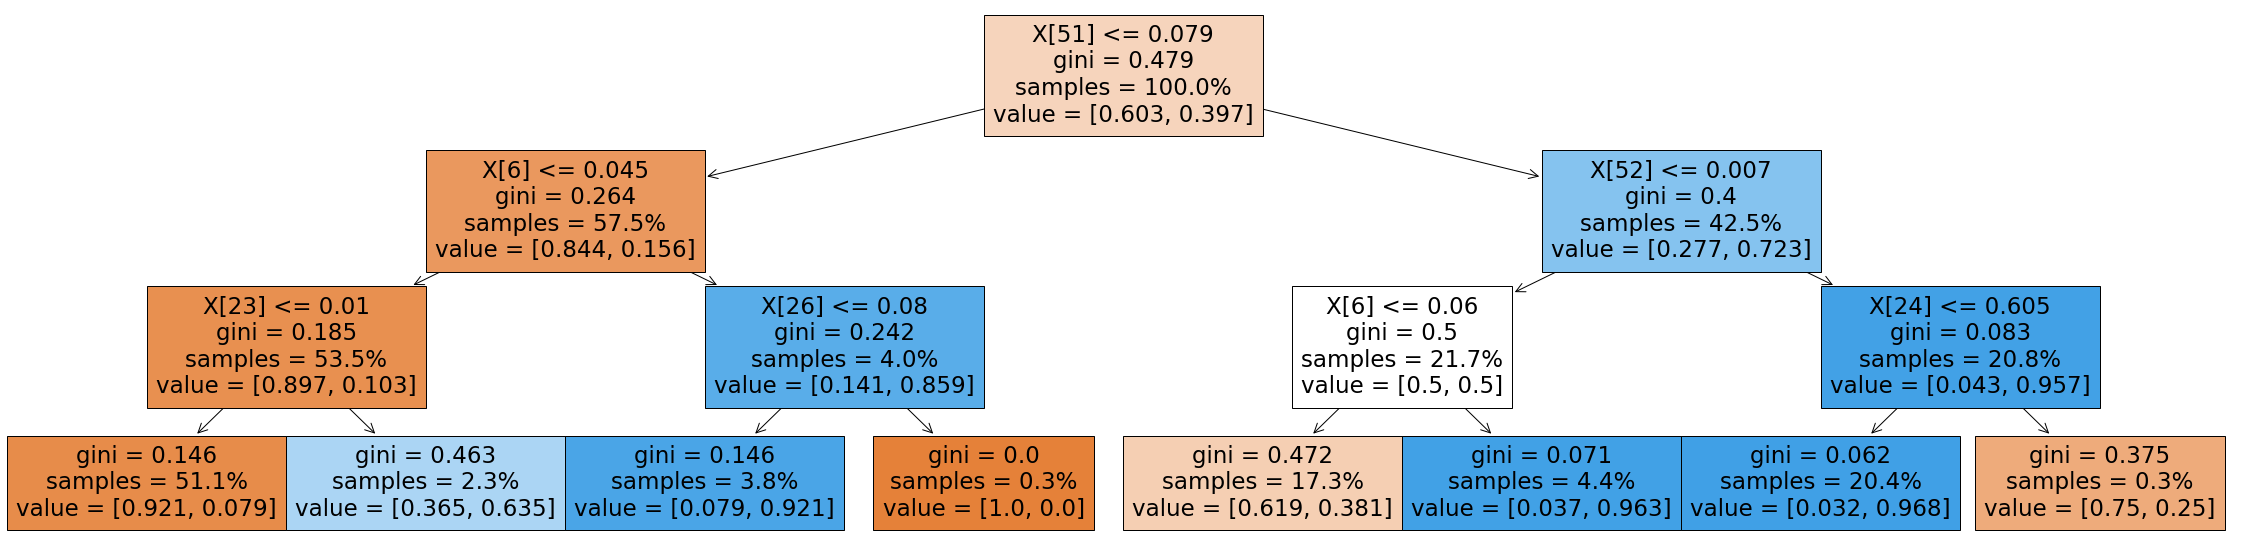

In [4]:
plt.figure(figsize=(40, 10))
plot_tree(clf, filled=True, proportion=True)
plt.show()

The depth-3 decision tree gets a classification accuracy of ~88%. Notice that the 51st and 52nd features were particularly useful in performing splits; this correspond to frequencies of certain characters that appear in emails (and it makes intuitive sense that an abundance of weird characters are good markers for spam).

In [5]:
print('Test accuracy:', clf.score(X_test, y_test))

Test accuracy: 0.875


We plot the confusion matrix:

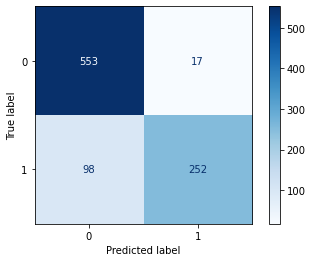

In [6]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Using the confusion matrix, we can compute the false positive and negative rates. We see that the decision tree will classify a spam email as nonspam more often that it will classify a nonspam email as spam. On one hand, this is desirable as we do not wish for important emails to be mistakenly marked as spam. On the other hand, this is undesirable as we may still receive some spam emails in our regular inbox.

In [7]:
y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()

print('False positive rate:', fp/(fp+tn))
print('False negative rate:', fn/(fn+tp))

False positive rate: 0.02982456140350877
False negative rate: 0.28


## Question (b)

We now train a decision tree with its default parameters. It performs better on test accuracy by $4.1$ points.

In [8]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print('Test accuracy:', clf.score(X_test, y_test))

Test accuracy: 0.9097826086956522


However the tree is much more complex and less easy to interpret. We don't really require you to say much here, except to realize that interpretation is much more difficult.

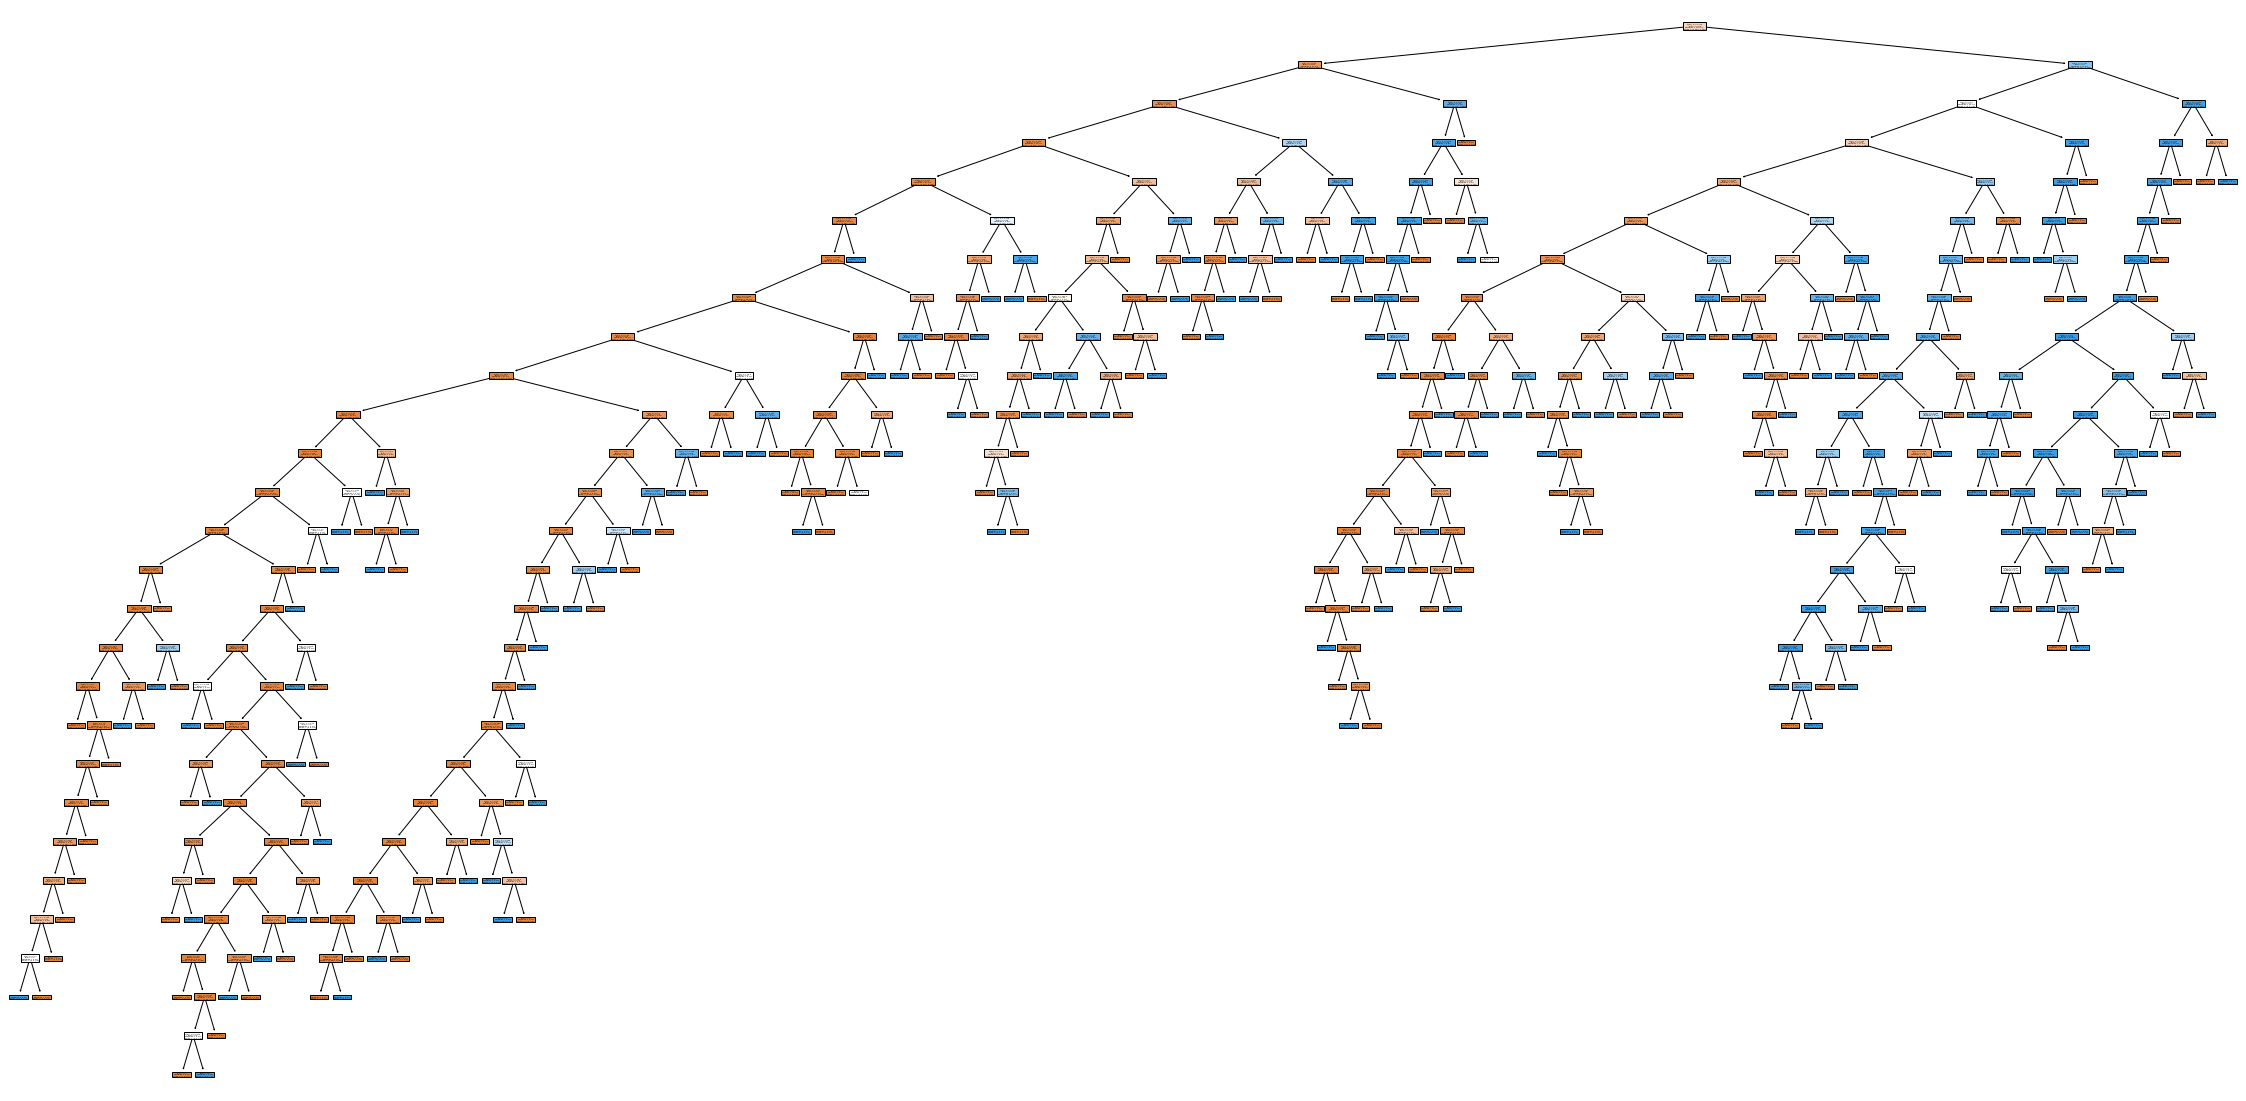

In [9]:
plt.figure(figsize=(40, 20))
plot_tree(clf, filled=True, proportion=True)
plt.show()

We plot the confusion matrix:

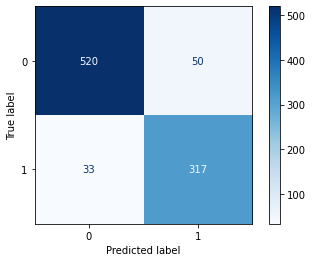

In [10]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

The new decision tree has significantly decreased the false positive and negative rates. As before, the decision tree will classify a spam email as nonspam more often that it will classify a nonspam email as spam.

In [11]:
y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()

print('False positive rate:', fp/(fp+tn))
print('False negative rate:', fn/(fn+tp))

False positive rate: 0.08771929824561403
False negative rate: 0.09428571428571429


We save the test accuracy from this decision tree for Question (c):

In [12]:
tree_score = clf.score(X_test, y_test)

## Question (c)

We train a $k$-nearest neighbor classifier using cross-validation:

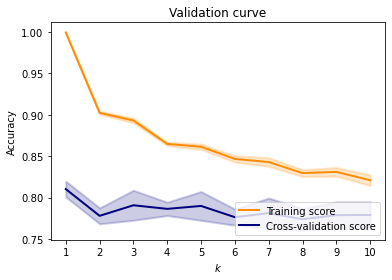

In [13]:
param_range = np.arange(1, 11)

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, 
                                             param_name='n_neighbors', param_range=param_range,
                                             scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation curve")
plt.xlabel("$k$")
plt.ylabel("Accuracy")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="lower right")
plt.xticks(param_range, param_range)
plt.show()

We will choose $k = 3$ because the choice $k = 1$ would interpolate the training data, which is generally considered not to be good statistical practice (although this is still debated till today!). You will get full credit for this part as long as you pick a value of $k$ that is consistent with your observed validation curve.

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)

We now train a $1$-layer neural network with $50$ hidden nodes (no cross-validation necessary).

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(50,))
mlp.fit(X_train, y_train)
mlp_score = mlp.score(X_test, y_test)

Finally, we train an SVM with an RBF kernel (again, no cross-validation necessary).

In [16]:
svm = SVC()
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)

We summarize the results in a table:

In [17]:
print(tabulate([['Decision tree', tree_score], 
                ['Nearest neighbors', knn_score],
                ['Neural network', mlp_score], 
                ['Support vector machine', svm_score]], 
               headers=['Classifier', 'Test accuracy']))

Classifier                Test accuracy
----------------------  ---------------
Decision tree                  0.909783
Nearest neighbors              0.813043
Neural network                 0.923913
Support vector machine         0.709783


Observe the suboptimal performance of the SVM. We will standardize the data then retrain all models using the same parameters. Make sure you follow the correct steps when standardizing training and test data: you should perform the scaling after the split so that test data information is not leaked into the training data, and use the training scaler to scale the test data.

In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform (X_test)

In [19]:
tree = DecisionTreeClassifier()
tree.fit(X_train_scaled, y_train)
tree_score = tree.score(X_test_scaled, y_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
knn_score = knn.score(X_test_scaled, y_test)

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
mlp.fit(X_train_scaled, y_train)
mlp_score = mlp.score(X_test_scaled, y_test)

svm = SVC()
svm.fit(X_train_scaled, y_train)
svm_score = svm.score(X_test_scaled, y_test)

All models, except the decision tree, now perform significantly better, with a bump of $+18.6$ points for the SVM! You may want to ponder why the scaling did not affect the decision tree's performance; this is because of the discrete "thresholding" nature of the decision tree classifier which makes it scale-invariant.

We will now plot the confusion matrices for all of the types of classifiers.

In [20]:
print(tabulate([['Decision tree', tree_score], 
                ['Nearest neighbors', knn_score],
                ['Neural network', mlp_score], 
                ['Support vector machine', svm_score]], 
               headers=['Classifier', 'Test accuracy']))

Classifier                Test accuracy
----------------------  ---------------
Decision tree                  0.917391
Nearest neighbors              0.905435
Neural network                 0.948913
Support vector machine         0.942391


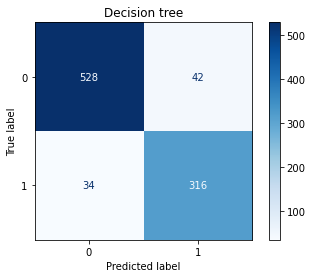

In [21]:
plot_confusion_matrix(tree, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("Decision tree")
plt.show()

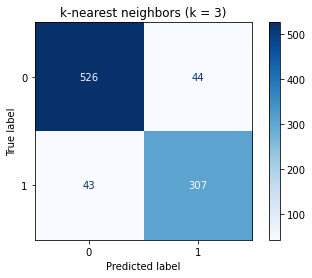

In [22]:
plot_confusion_matrix(knn, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("k-nearest neighbors (k = 3)")
plt.show()

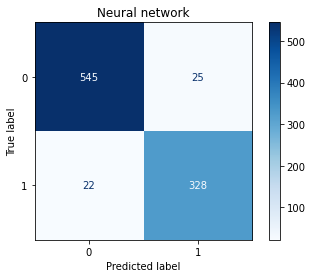

In [23]:
plot_confusion_matrix(mlp, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("Neural network")
plt.show()

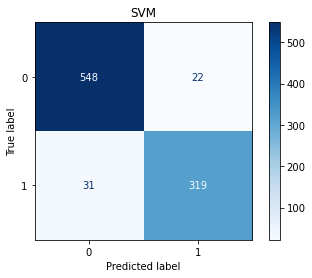

In [24]:
plot_confusion_matrix(svm, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title("SVM")
plt.show()

Observe that the neural network achieves the best performance on all metrics: accuracy, false positive rate, and false negative rate. Therefore, it is our preferred model. We recap these metrics for the neural network below. Note that you may not have obtained this exact order of preference among models, but as long as your reported values are within reasonable range of the solutions provided here (and your order of preference is consistent with the reported values), you will get full credit.

In terms of justifying the design choice, we used accuracy metrics here because interpretation is not strictly necessary for spam classification. It is quite easy to tell a classifier to ignore a certain feature of your email (say if you receive a lot of email with many exclamation points!) and you don't really care about asking the classifier to produce justification for *why* it classified email as ham/spam. In other words, this is a prediction-driven task, which is why we go with a neural network.

If you are able to justify your own design choice in a compelling way, you will get full credit.